In [2]:
import datetime
import pytz

import matplotlib.pyplot as plt
import mplcyberpunk

from pathlib import Path
import pandas as pd
import numpy as np
from astropy.io import fits
import astropy.wcs as fitswcs
import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, get_moon, Angle
from astropy.time import Time
from astropy.table import Table
import astroplan
from specutils.spectra.spectrum1d import Spectrum1D
from astropy.visualization import quantity_support
from specutils.io.registers import custom_writer

_ = quantity_support()
plt.style.use("cyberpunk")

In [3]:
@custom_writer("fits-writer")
def generic_fits(spectrum, file_name, overwrite=False, **kwargs):
    flux = spectrum.flux.value
    disp = spectrum.spectral_axis.value
    meta = spectrum.meta

    tab = Table([disp, flux], names=("spectral_axis", "flux"), meta=meta)

    tab.write(file_name, format="fits", overwrite=overwrite)

In [4]:
MMT_LOCATION = EarthLocation.from_geodetic("-110:53:04.4", "31:41:19.6", 2600 * u.m)
MMT = astroplan.Observer(name="MMTO", location=MMT_LOCATION, timezone="US/Arizona", pressure=0*u.mbar)

In [5]:
def load_spectrum(fitsfile):
    hdul = fits.open(fitsfile)
    hdu = hdul[0]
    hdu.verify('fix')
    h = hdul[0].header
    s_hdr = {
        'CDELT1': h['CDELT1'],
        'CRVAL1': h['CRVAL1'],
        'CUNIT1': 'Angstrom',
        'CTYPE1': h['CTYPE1'],
        'CRPIX1': h['CRPIX1']
    }
    counts = hdul[0].data[2][0] / h['EXPTIME']
    s_wcs = fitswcs.WCS(header=s_hdr)
    sp = Spectrum1D(flux=counts * u.count/u.second, wcs=s_wcs)
    return sp

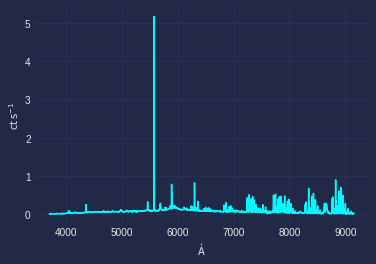

In [6]:
s = load_spectrum("2012.0316/skysub_m87.2012a_3/skydir/001.sky.ms.fits")
#s = Spectrum1D.read("2012.0316/skysub_m87.2012a_3/skydir/001.sky.ms.fits", format='wcs1d-fits')
plt.step(s.spectral_axis, s.flux)
plt.show()
s.write("blah.fits", format="fits-writer", overwrite=True)

In [7]:
drop = ['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NAXIS3', 'EXTEND', 'CTYPE1', 'CRVAL1', 'CRPIX1', 'CDELT1', 'CDELT2']
def combine_skies(obsdir):
    """
    Combine data from multiple sky fibers into one sky spectrum
    """
    p = Path(obsdir) / "skydir"
    skies = list(p.glob("*.ms.fits"))
    n = len(skies)
    init_sky = skies.pop(0)
    init_spec = load_spectrum(init_sky)
    hdu = fits.open(skies[0])[0]
    hdu.verify('fix')
    hdr = hdu.header
    utc = Time(hdr['DATE-OBS'])
    coords = SkyCoord(f"{hdr['RA']} {hdr['DEC']}", unit=(u.hourangle, u.deg))
    aa_frame = AltAz(obstime=utc, location=MMT_LOCATION)
    alt_az = coords.transform_to(aa_frame)
    hdr['ALT'] = alt_az.alt.to_string()
    hdr['AZ'] = alt_az.az.to_string()
    moon = get_moon(utc, MMT_LOCATION)
    moon_aa = moon.transform_to(aa_frame)
    hdr['MOON_ALT'] = moon_aa.alt.to_string()
    hdr['MOON_AZ'] = moon_aa.az.to_string()
    illum = 100 * astroplan.moon_illumination(utc)
    hdr['MOON_ILL'] = f"{illum:.0f}"
    for k in drop:
        del hdr[k]
    for sp in skies:
        init_spec += load_spectrum(sp)
    comb_sp = Spectrum1D(spectral_axis=init_spec.spectral_axis, flux=init_spec.flux/n, wcs=init_spec.wcs)
    comb_sp.meta['header'] = hdr
    return comb_sp

In [8]:
csp = combine_skies("2020.1025/skysub_m31_pne_20_8")
csp.write("blah.fits",  overwrite=True)

In [49]:
list(Path(".").glob("20*"))len()

826

In [ ]:
datadirs = Path(".").glob("20*")
for d in datadirs:
    obsdirs = d.glob("*")
    for o in obsdirs:
        if o.is_dir():
            outfile = f"{str(o)}_comb.fits"
            if Path(outfile).exists():
                print(f"Skipping {outfile}...")
            else:
                print(f"Processing {outfile}...")
                sp = combine_skies(o)
                sp.write(outfile, overwrite=True)

In [87]:
with open("sky_spectra.csv", 'w') as outf:
    outf.write("#file,ut,alt,az,moon_alt,moon_az,moon_ill\n")
    with open("comblist", 'r') as fp:
        for f in fp.readlines():
            f = f.strip()
            sp = Spectrum1D.read(f)
            outstr = (
                f"{f},"
                f"{sp.meta['header']['DATE-OBS']},"
                f"{Angle(sp.meta['header']['ALT']).value:.2f},"
                f"{Angle(sp.meta['header']['AZ']).value:.2f},"
                f"{Angle(sp.meta['header']['MOON_ALT']).value:.2f},"
                f"{Angle(sp.meta['header']['MOON_AZ']).value:.2f},"
                f"{sp.meta['header']['MOON_ILL']}"
                "\n"
            )
            outf.write(outstr)

In [10]:
df = pd.read_csv("sky_spectra.csv")
moonfree = df[(df['moon_alt'] < -6)]
moonfree

,#file,ut,alt,az,moon_alt,moon_az,moon_ill
1,./2004.0413/skysub_a2034.bg_1_comb.fits,2004-04-13T08:25:25,81.18,75.47,-17.42,107.26,37
3,./2004.0413/skysub_F2.20.bg_1_comb.fits,2004-04-13T05:53:13,56.71,278.43,-47.97,91.12,38
4,./2004.0414/skysub_F2.bg_1_comb.fits,2004-04-14T05:11:49,65.04,274.96,-65.06,67.04,28
5,./2004.0414/skysub_F2.bg_2_comb.fits,2004-04-14T07:00:59,41.07,284.86,-43.32,87.36,27
6,./2004.0415/skysub_F2.bg_3_comb.fits,2004-04-15T05:48:01,55.37,278.13,-64.16,53.43,19
...,...,...,...,...,...,...,...
4126,./2020.1013/skysub_m31_pne_20_9_comb.fits,2020-10-13T08:16:47,66.13,300.54,-16.84,60.23,17
4129,./2020.1024/skysub_jiang_c2_1_comb.fits,2020-10-24T12:04:06,65.47,80.09,-59.19,282.18,60
4132,./2020.1024/skysub_Rank13_1_comb.fits,2020-10-24T08:14:37,50.94,204.84,-13.27,252.44,58
4133,./2020.1025/skysub_jiang_c2_1_comb.fits,2020-10-25T11:29:55,59.13,78.40,-41.03,273.43,69


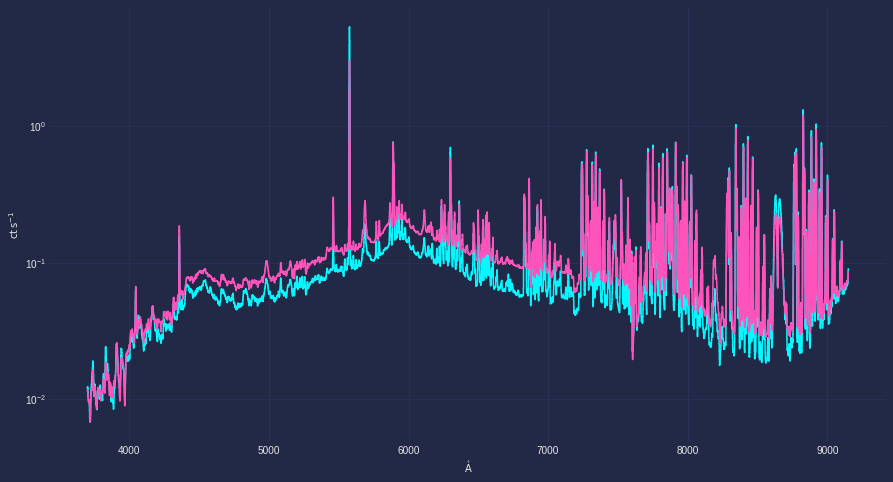

In [11]:
test = Spectrum1D.read("./2020.1013/skysub_m31_pne_20_9_comb.fits")
t2 = Spectrum1D.read("./2020.1024/skysub_jiang_c2_1_comb.fits")
plt.figure(figsize=[15,8])
plt.step(test.spectral_axis, test.flux)
plt.step(t2.spectral_axis, t2.flux)
plt.yscale('log')
plt.show()